In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # import Axes3D from `mpl_toolkits.mplot3d`
import matplotlib.animation as animation
import math
import random
from scipy.fft import fft, ifft
from scipy.stats import norm
import levy
import matplotlib.mlab as mlab
from scipy.optimize import leastsq
from scipy.optimize import curve_fit
from scipy.integrate import quad

plt.style.use('ggplot') # use "ggplot" style for graphs
random.seed()

In [2]:
# Function implementing Levy flight according to doi:10.1016/j.cor.2011.09.026
def levy_dist(n, m, beta, nump=1):
    # nump = number of particles, default 1
    # n = number of steps
    # m = number of dimensions
    # beta = power law index, where 1 < beta < 2
    
    # Used for numerator
    num = math.gamma(1+beta)*math.sin(math.pi*beta/2)
    
    # Used for denominator
    den = math.gamma((1+beta)/2)*beta*2**((beta-1)/2)
    
    # Standard deviation
    sigma_u = (num/den)**(1/beta)
    
    # Draw samples
    if nump == 1:
        u = np.random.normal(scale=sigma_u**2, size=(n,m))
        v = np.random.normal(size=(n,m))
    else:
        u = np.random.normal(scale=sigma_u**2, size=(nump,n,m))
        v = np.random.normal(size=(nump,n,m))
    
    # n levy steps in m dimensions
    levyd = u/(np.power(np.abs(v), 1/beta))
    
    return levyd

# Function to determine value of alpha
def alpha(n, m, beta, alpha0, nump=1):
    lev_i = levy_dist(n, m, beta, nump)
    lev_j = levy_dist(n, m, beta, nump)
    
    if nump == 1:
        sol_i = np.zeros((n,m))
        sol_j = np.zeros((n,m))
        for i in range(1,n):
            sol_i[i,:] = sol_i[i-1,:] + lev_i[i,:]
            sol_j[i,:] = sol_j[i-1,:] + lev_j[i,:]
    
    else:
        sol_i = np.zeros((nump,n,m))
        sol_j = np.zeros((nump,n,m))
        for i in range(1,n):
            sol_i[:,i,:] = sol_i[:,i-1,:] + lev_i[:,i,:]
            sol_j[:,i,:] = sol_j[:,i-1,:] + lev_j[:,i,:]

    
    alpha = alpha0*(sol_j-sol_i)
    
    return alpha

def fourier_levy(k,alpha,beta):
    
    Fk = np.exp(-alpha*np.power(np.abs(k), beta))
    invF = ifft(Fk)
    
    return invF

def gaussian(x, sig):
    return np.exp(-np.power(x - 0, 2.) / (2 * np.power(sig, 2.)))/(np.sqrt(2*np.pi)*sig)

def cauchy(x, gamma):
    return (1/(np.pi))*((gamma)/(np.power(x, 2)+gamma**2))

def levy_char(x, t, c):
    return np.exp(-np.sqrt(-2j*c*t))

def levy_int(x, t, c):
    exp = levy_char(x, t, c)
    I = quad(integrand, 0, len(t), args=(x,c))
    return I[0]

def anom_diff(t, K, a):
    return K*np.power(t, a)

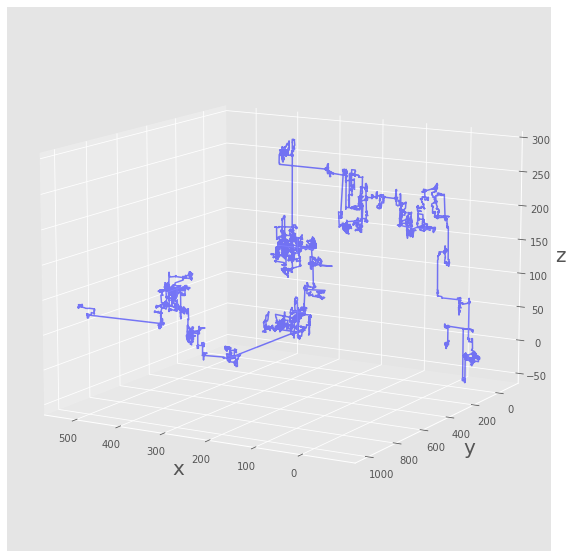

In [3]:
# Set parameters
num = 500 # number of particles
alpha0 = 0.1 # alpha0 parameter
var = alpha0*2
n = 10000 # number of steps
m = 3 # dimensions
beta = 1.5 # power law index

x = np.zeros(n)
y = np.zeros(n)
z = np.zeros(n)

xg = np.zeros(n)
yg = np.zeros(n)
zg = np.zeros(n)

# Generate levy steps
lev = levy_dist(n,m,beta)
gauss = np.random.normal(loc=0, scale=var/2, size=(n,m))
#lev = lev*10**(15)

alph = alpha(n,m,beta,alpha0)

"""for i in range(1,len(lev)):
    x[i] = x[i-1] + lev[i,0]
    y[i] = y[i-1] + lev[i,1]
    z[i] = z[i-1] + lev[i,2]"""
    
for i in range(1,n):
    #x[i] = x[i-1] + np.multiply(alph[i,0],lev[i,0])
    #y[i] = y[i-1] + np.multiply(alph[i,1],lev[i,1])
    #z[i] = z[i-1] + np.multiply(alph[i,2],lev[i,2])
    x[i] = x[i-1] + lev[i,0]
    y[i] = y[i-1] + lev[i,1]
    z[i] = z[i-1] + lev[i,2]
    
# Plot
#jet= plt.get_cmap('jet')
#colors = iter(jet(np.linspace(0,1,num)))

fig = plt.figure(figsize=(10,10)) # set fig with its size 10 x 10 inch
ax = fig.add_subplot(111,projection='3d') # creates an additional axis to the standard 
ax.set_xlabel(r"x",fontsize=20) # set x-label
ax.set_ylabel(r"y",fontsize=20) # set y-label
ax.set_zlabel(r"z",fontsize=20) # set z-label
ax.view_init(elev=12,azim=120) # set view point
ax.plot(x,y,z,color='b',alpha=0.5) # plot trajectiries of all particle
#ax.plot(xg,yg,zg,color='r',alpha=0.5) # plot trajectiries of all particle
plt.savefig('Figures/levy flight beta 1.5 3D single.pdf', bbox_inches='tight')
plt.savefig('Figures/levy flight beta 1.5 3D single.png', bbox_inches='tight')
plt.show() # draw plots

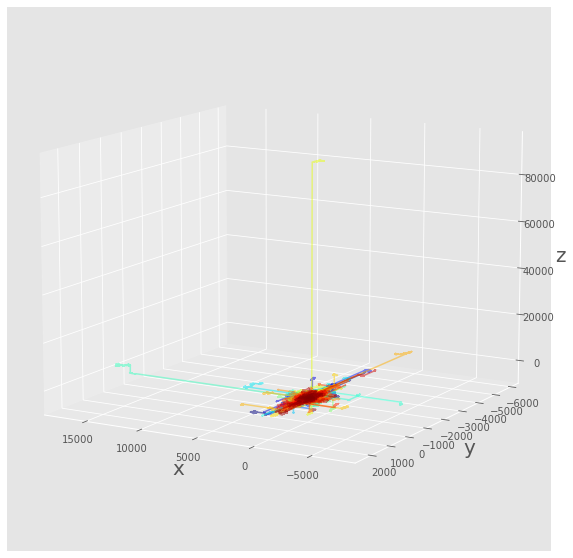

In [4]:
x = np.zeros((num,n))
y = np.zeros((num,n))
z = np.zeros((num,n))

# Generate levy steps
lev = levy_dist(n,m,beta,num)

alph = alpha(n,m,beta,alpha0,num)

for i in range(1,n):
    #x[:,i] = x[:,i-1] + np.multiply(alph[:,i,0], lev[:,i,0])
    #y[:,i] = y[:,i-1] + np.multiply(alph[:,i,1], lev[:,i,1])
    #z[:,i] = z[:,i-1] + np.multiply(alph[:,i,2], lev[:,i,2])
    x[:,i] = x[:,i-1] + lev[:,i,0]
    y[:,i] = y[:,i-1] + lev[:,i,1]
    z[:,i] = z[:,i-1] + lev[:,i,2]

# Plot
jet= plt.get_cmap('jet')
colors = iter(jet(np.linspace(0,1,num)))

fig = plt.figure(figsize=(10,10)) # set fig with its size 10 x 10 inch
ax = fig.add_subplot(111,projection='3d') # creates an additional axis to the standard 
ax.set_xlabel(r"x",fontsize=20) # set x-label
ax.set_ylabel(r"y",fontsize=20) # set y-label
ax.set_zlabel(r"z",fontsize=20) # set z-label
ax.view_init(elev=12,azim=120) # set view point
for i in range(num): # repeat from n=0 to nump-1
    ax.plot(x[i,:],y[i,:],z[i,:],color=next(colors),alpha=0.5) # plot trajectiries of all particles
plt.savefig('Figures/levy flight beta 1.5 3D paths.pdf', bbox_inches='tight')
plt.savefig('Figures/levy flight beta 1.5 3D paths.png', bbox_inches='tight')
plt.show() # draw plots

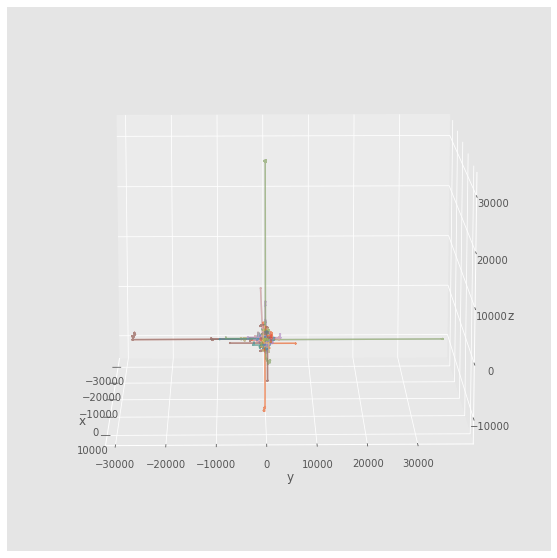

In [5]:
#jet= plt.get_cmap('jet')
#colors = iter(jet(np.linspace(0,1,num)))

# Create a figure and a 3D Axes
fig = plt.figure(figsize=(10,10)) # set fig with its size 10 x 10 inch
ax = fig.add_subplot(111,projection='3d') # creates an additional axis to the standard 
ax.set_xlabel(r"x",fontsize=12) # set x-label
ax.set_ylabel(r"y",fontsize=12) # set y-label
ax.set_zlabel(r"z",fontsize=12) # set z-label

# Create an init function and the animate functions.
# Both are explained in the tutorial. Since we are changing
# the the elevation and azimuth and no objects are really
# changed on the plot we don't have to return anything from
# the init and animate function. (return value is explained
# in the tutorial.
def init():
    for i in range(num): # repeat from n=0 to nump-1
        ax.plot(x[i,:],y[i,:],z[i,:],alpha=0.5) # plot trajectiries of all particle
    return fig,

def animate(i):
    ax.view_init(elev=12., azim=i)
    return fig,

# Animate
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=360, interval=20, blit=True)
# Save
anim.save(r'Figures/levy 1.5 3D rotation.mp4', fps=30, extra_args=['-vcodec', 'libx264'])

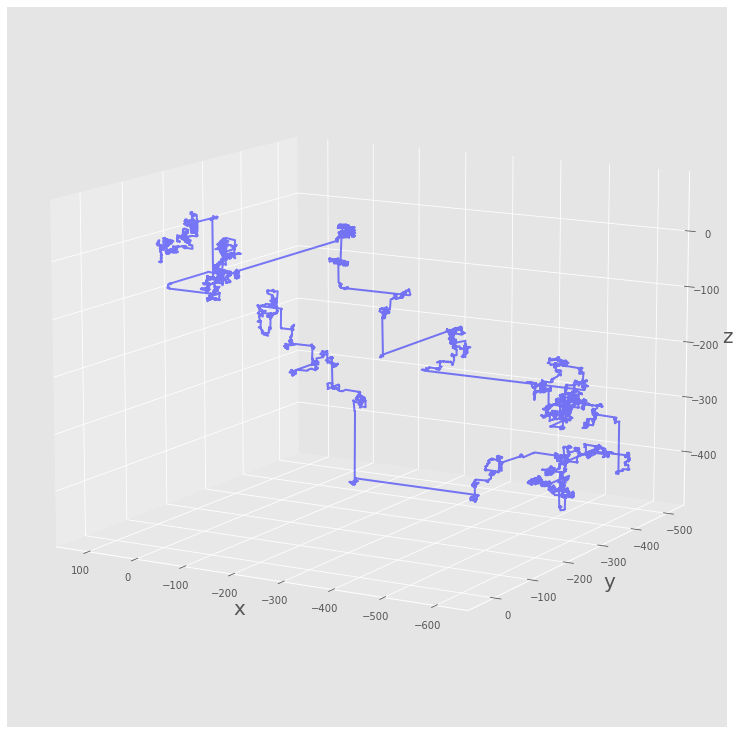

In [7]:
# ANIMATION FUNCTION
def func(nums, dataSet, line):
    # NOTE: there is no .set_data() for 3 dim data...
    line.set_data(dataSet[0:2, :nums])    
    line.set_3d_properties(dataSet[2, :nums])    
    return line

# THE DATA POINTS
dataSet = np.array([x[0,:], y[0,:], z[0,:]])
numDataPoints = len(x[0,:])
 
# GET SOME MATPLOTLIB OBJECTS
fig = plt.figure(figsize=(10,10))
ax = Axes3D(fig)
 
# NOTE: Can't pass empty arrays into 3d version of plot()
line = plt.plot(dataSet[0], dataSet[1], dataSet[2], alpha=0.5, lw=2, c='b')[0] # For line plot
 
# AXES PROPERTIES]
# ax.set_xlim3d([limit0, limit1])
#ax.set_xlim3d(0,nx) # set x-range
#ax.set_ylim3d(0,ny) # set y-range
#ax.set_zlim3d(0,nz) # set z-range
ax.set_xlabel(r"x",fontsize=20) # set x-label
ax.set_ylabel(r"y",fontsize=20) # set y-label
ax.set_zlabel(r"z",fontsize=20) # set z-label
ax.view_init(elev=12,azim=120) # set view point
 
# Creating the Animation object
line_ani = animation.FuncAnimation(fig, func, frames=numDataPoints, fargs=(dataSet,line), interval=5, blit=False)
line_ani.save(r'Figures/levy 1.5 3D single.mp4')

plt.show() # draw plots

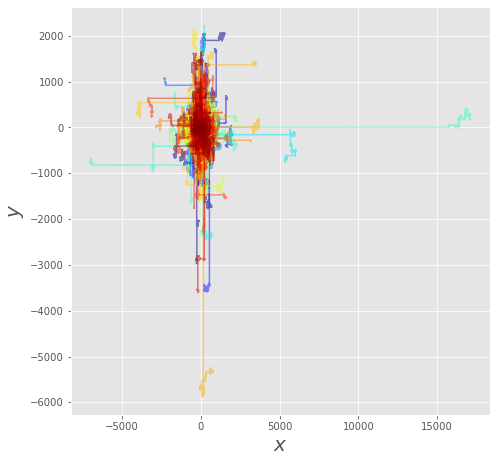

In [5]:
jet= plt.get_cmap('jet')
colors = iter(jet(np.linspace(0,1,num)))

fig, ax = plt.subplots(figsize=(7.5,7.5)) # set fig with its size 7.5 x 7.5 inch
#ax.set_title('{:.1f} ms'.format(nums*dt*1000))
ax.set_xlabel(r"$x$", fontsize=20) # set x-label
ax.set_ylabel(r"$y$", fontsize=20) # set y-label
#ax.set_xlim(0,nx) # set x-range
#ax.set_ylim(0,ny) # set y-range
for i in range(num): # repeat from n=0 to nump-1
    ax.plot(x[i,:],y[i,:],color=next(colors),alpha=0.5) # plot trajectiries of all particles
plt.savefig('Figures/levy flight beta 1.5 2D paths.pdf', bbox_inches='tight')
plt.show() # draw plots

0
28.14948902840938
-140.7474451420469
140.7474451420469
100


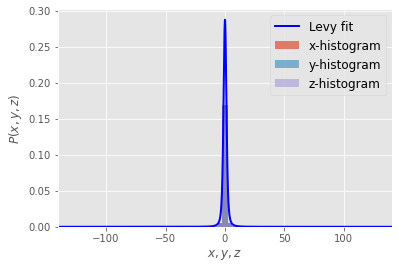

In [6]:
x_diff = np.diff(x, axis=1)
y_diff = np.diff(y, axis=1)
z_diff = np.diff(z, axis=1)

x_diff = x_diff.flatten()
y_diff = y_diff.flatten()
z_diff = z_diff.flatten()

#print(np.amax(x_diff))
#print(np.amin(x_diff))

#print(np.amax(y_diff))
#print(np.amin(y_diff))

#print(np.amax(z_diff))
#print(np.amin(z_diff))

stepsize_array = np.concatenate((x_diff,y_diff,z_diff), axis=None)
(ave, std) = norm.fit(stepsize_array,floc=0)
#lev_param = levy.fit_levy(np.mean([x_diff,y_diff,z_diff], axis=0),mu=0.0)
#print(lev_param)
#lev_alpha, lev_beta, ave, std = lev_param[0].get('0')

nmin=ave-std*5
nmax=ave+std*5
nbin=int((nmax-nmin)/4)
nbin = 100
print(ave)
print(std)
print(nmin)
print(nmax)
print(nbin)

fig = plt.figure()
ax = fig.add_subplot(111)

height1, _, _ = ax.hist(x_diff,range=[nmin,nmax],bins=nbin,density=True, stacked=True, alpha=0.7,label=r'x-histogram') # plot normalized histogram of L
height2, _, _ = ax.hist(y_diff,range=[nmin,nmax],bins=nbin,density=True, stacked=True, alpha=0.6,label=r'y-histogram') # plot normalized histogram of L
height3, _, _ = ax.hist(z_diff,range=[nmin,nmax],bins=nbin,density=True, stacked=True, alpha=0.5,label=r'z-histogram') # plot normalized histogram of L
height4, bins, _ = ax.hist(stepsize_array,range=[nmin,nmax],bins=nbin,density=True, stacked=True, alpha=0) # plot to get parameters, dont want visible

bin_centers = bins[:-1] + np.diff(bins) / 2
xyz_fit = np.linspace(bins[0], bins[-1], 10000)
#levy_line = levy.levy(xyz_fit, lev_alpha, lev_beta, lev_ave, lev_std)
levy_line = levy.levy(xyz_fit, 1.5, 0, 0, 1)

#ax.plot(xyz_fit, gaussian(xyz_fit, *popt),lw=2,color='b', label=r'Gaussian mean')
#ax.plot(bins,best_fit_line,lw=2,color='k',label=r'Norm fit') # plot y vs. x with blue line
ax.plot(xyz_fit,levy_line,lw=2,color='b',label=r'Levy fit') # plot y vs. x with blue line
#ax.set_title(r'y-axis particle distribution')
ax.set_xlabel(r'$x,y,z$',fontsize=12) # set x-label
ax.set_ylabel(r'$P(x,y,z)$',fontsize=12) # set y-label
ax.legend(fontsize=12, loc='upper right') # set legends
ax.set_xlim(nmin,nmax) # set x-range
plt.savefig('Figures/levy xyz step size.pdf', bbox_inches='tight')
plt.show() # display plots

(par=0, alpha=1.50, beta=0.00, mu=0.00, sigma=326.34, 3925.2672036193917)
[  1.5          0.           0.         326.34138962]
0.0
326.3413896204097


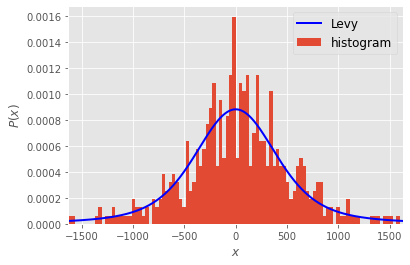

In [7]:
#ave = 0 # Average position i.e. starting position
#std = np.sqrt(2*dmsd*t[-1]) # Standard deviation i.e. sqrt(2Dt)
#lev_param = levy.fit_levy(x[:,-1],alpha=0.5, beta=1.0, mu=0.0)
lev_param = levy.fit_levy(x[:,-1],mu=0.0,alpha=1.5,beta=0)
print(lev_param)
lev_alpha, lev_beta, ave, std = lev_param[0].get('0')
print(lev_param[0].get('1'))

#(ave, std) = levy.fit(x[:,-1], loc=0)

nmin=ave-std*5
nmax=ave+std*5
nbin=int((nmax-nmin)/4)
nbin = 100
print(ave)
print(std)

fig = plt.figure()
ax = fig.add_subplot(111)

height, bins, _ = ax.hist(x[:,-1],range=[nmin,nmax],bins=nbin,density=True, stacked=True) # plot normalized histogram of L
bin_centers = bins[:-1] + np.diff(bins) / 2

#xi = np.arange(nmin,nmax,0.01/std) # create array of x from nmin to nmax with increment
#yi = np.exp(-(xi-ave)**2/(2*std**2))/np.sqrt(2*np.pi*std**2) # calculate the theoretical

#popt, _ = curve_fit(levy_fit, bin_centers, height, p0=[2e6])
#print(popt)

x_fit = np.linspace(bins[0], bins[-1], 10000)
best_fit_line = levy.levy(x_fit, lev_alpha, lev_beta, ave, std)

#ax.plot(xi,yi,lw=2,color='g') # plot y vs. x with blue line
#ax.plot(x_fit, levy_fit(x_fit, *popt),lw=2,color='b')
ax.plot(x_fit,best_fit_line,lw=2,color='b') # plot y vs. x with blue line
#ax.set_title(r'x-axis particle distribution')
ax.set_xlabel(r'$x$',fontsize=12) # set x-label
ax.set_ylabel(r'$P(x)$',fontsize=12) # set y-label
#ax.axvline(x=0, color='k', alpha=0.5, lw=2 ,linestyle='--')
ax.legend([r'Levy',r'histogram'], fontsize=12, loc='upper right') # set legends
ax.set_xlim(nmin,nmax) # set x-range
plt.savefig('Figures/levy flight beta 1.5 x distr.pdf', bbox_inches='tight')
plt.show() # display plots

(par=0, alpha=1.50, beta=0.00, mu=0.00, sigma=300.20, 3861.715104284459)
0.0
300.20086706331864


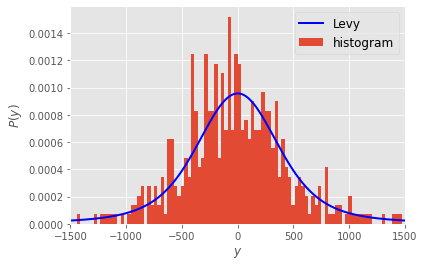

In [8]:
#ave = 0 # Average position i.e. starting position
#std = np.sqrt(2*dmsd*t[-1]) # Standard deviation i.e. sqrt(2Dt)
lev_param = levy.fit_levy(y[:,-1],mu=0.0,alpha=1.5,beta=0)
print(lev_param)
lev_alpha, lev_beta, ave, std = lev_param[0].get('0')

nmin=ave-std*5
nmax=ave+std*5
nbin=int((nmax-nmin)/4)
nbin = 100
print(ave)
print(std)

fig = plt.figure()
ax = fig.add_subplot(111)

height, bins, _ = ax.hist(y[:,-1],range=[nmin,nmax],bins=nbin,density=True, stacked=True) # plot normalized histogram of L
bin_centers = bins[:-1] + np.diff(bins) / 2

#xi = np.arange(nmin,nmax,0.01/std) # create array of x from nmin to nmax with increment
#yi = np.exp(-(xi-ave)**2/(2*std**2))/np.sqrt(2*np.pi*std**2) # calculate the theoretical

#popt, _ = curve_fit(gaussian, bin_centers, height, p0=[2e-29])
#print(popt)

y_fit = np.linspace(bins[0], bins[-1], 10000)
best_fit_line = levy.levy(y_fit, lev_alpha, lev_beta, ave, std)

#ax.plot(xi,yi,lw=2,color='g') # plot y vs. x with blue line
ax.plot(y_fit,best_fit_line,lw=2,color='b') # plot y vs. x with blue line
#ax.plot(y_fit, gaussian(y_fit, *popt),lw=2,color='b')
#ax.set_title(r'y-axis particle distribution')
ax.set_xlabel(r'$y$',fontsize=12) # set x-label
ax.set_ylabel(r'$P(y)$',fontsize=12) # set y-label
ax.legend([r'Levy',r'histogram'], fontsize=12, loc='upper right') # set legends
ax.set_xlim(nmin,nmax) # set x-range
plt.savefig('Figures/levy flight beta 1.5 y distr.pdf', bbox_inches='tight')
plt.show() # display plots

(par=0, alpha=1.50, beta=0.00, mu=0.00, sigma=344.28, 3970.849918479214)
0.0
344.27903111079746


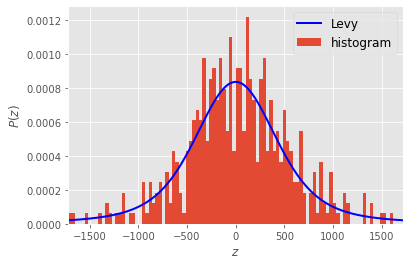

In [9]:
#ave = 0 # Average position i.e. starting position
#std = np.sqrt(2*dmsd*t[-1]) # Standard deviation i.e. sqrt(2Dt)
lev_param = levy.fit_levy(z[:,-1],mu=0.0,alpha=1.5,beta=0)
print(lev_param)
lev_alpha, lev_beta, ave, std = lev_param[0].get('0')

nmin=ave-std*5
nmax=ave+std*5
nbin=int((nmax-nmin)/4)
nbin = 100
print(ave)
print(std)

fig = plt.figure()
ax = fig.add_subplot(111)

height, bins, _ = ax.hist(z[:,-1],range=[nmin,nmax],bins=nbin,density=True, stacked=True) # plot normalized histogram of L
bin_centers = bins[:-1] + np.diff(bins) / 2

#xi = np.arange(nmin,nmax,0.01/std) # create array of x from nmin to nmax with increment
#yi = np.exp(-(xi-ave)**2/(2*std**2))/np.sqrt(2*np.pi*std**2) # calculate the theoretical

#best_fit_line = norm.pdf(bins, mu, sigma)

#popt, _ = curve_fit(gaussian, bin_centers, height, p0=[2e-29])
#print(popt)

z_fit = np.linspace(bins[0], bins[-1], 10000)
best_fit_line = levy.levy(z_fit, lev_alpha, lev_beta, ave, std)

#ax.plot(xi,yi,lw=2,color='g') # plot y vs. x with blue line
ax.plot(z_fit,best_fit_line,lw=2,color='b') # plot y vs. x with blue line
#ax.plot(z_fit, gaussian(z_fit, *popt),lw=2,color='b')
#ax.set_title(r'z-axis particle distribution')
ax.set_xlabel(r'$z$',fontsize=12) # set x-label
ax.set_ylabel(r'$P(z)$',fontsize=12) # set y-label
ax.legend([r'Levy',r'histogram'], fontsize=12, loc='upper right') # set legends
ax.set_xlim(nmin,nmax) # set x-range
plt.savefig('Figures/levy flight beta 1.5 z distr.pdf', bbox_inches='tight')
plt.show() # display plots

(par=0, alpha=1.50, beta=0.00, mu=0.00, sigma=323.12, 11760.132642660374)
0.0
323.1162635418268


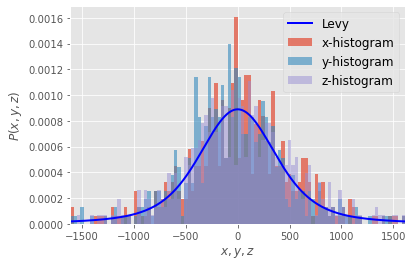

In [10]:
xyz_array = np.concatenate((x[:,-1],y[:,-1],z[:,-1]), axis=None)
lev_param = levy.fit_levy(xyz_array,mu=0.0,alpha=1.5,beta=0)
print(lev_param)
lev_alpha, lev_beta, ave, std = lev_param[0].get('0')

nmin=ave-std*5
nmax=ave+std*5
nbin=int((nmax-nmin)/4)
nbin = 100
print(ave)
print(std)

fig = plt.figure()
ax = fig.add_subplot(111)

height, bins, _ = ax.hist(x[:,-1],range=[nmin,nmax],bins=nbin,density=True, stacked=True, alpha=0.7,label=r'x-histogram') # plot normalized histogram of L
ax.hist(y[:,-1],range=[nmin,nmax],bins=nbin,density=True, stacked=True, alpha=0.6,label=r'y-histogram') # plot normalized histogram of L
ax.hist(z[:,-1],range=[nmin,nmax],bins=nbin,density=True, stacked=True, alpha=0.5,label=r'z-histogram') # plot normalized histogram of L

xyz_fit = np.linspace(bins[0], bins[-1], 10000)
best_fit_line = levy.levy(z_fit, lev_alpha, lev_beta, ave, std)

ax.plot(xyz_fit,best_fit_line,lw=2,color='b',label=r'Levy') # plot y vs. x with blue line
#ax.plot(xyz_fit,lev_mean,lw=2,color='k',label=r'Levy mean') # plot y vs. x with blue line
#ax.plot(xyz_fit,product_lev,lw=2,color='r',label=r'Levy product') # plot y vs. x with blue line
#ax.set_title(r'y-axis particle distribution')
ax.set_xlabel(r'$x,y,z$',fontsize=12) # set x-label
ax.set_ylabel(r'$P(x,y,z)$',fontsize=12) # set y-label
ax.legend(fontsize=12, loc='upper right') # set legends
ax.set_xlim(nmin,nmax) # set x-range
plt.savefig('Figures/levy flight beta 1.5 xyz distr.pdf', bbox_inches='tight')
plt.show() # display plots

[73.98747699  1.38876325]
[27.31470833]
D = 356.28766819745636 (Simulation via MSD)


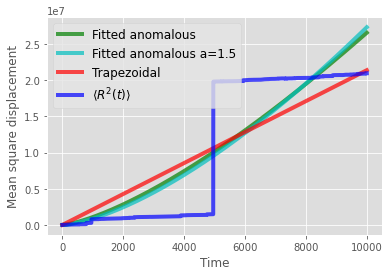

In [11]:
R = np.zeros((num,n,m))
R[:,:,0] = x[:,:]
R[:,:,1] = y[:,:]
R[:,:,2] = z[:,:]
dt = 1
time = np.arange(n)

# mean square displacement vs time
msd1 = np.zeros([n, num])
for i in range(n): # loop over time steps
    diff = R[:,i,:] - 0
    pos2 = np.power(diff, 2)
    summ = np.sum(pos2, axis=1)
    msd1[i,:] = summ
    
msd = np.mean(msd1, axis=1)
#print(msd1)
#print(msd)

dmsd = np.trapz(msd, dx=dt)/ (3*(n*dt)**2) # integrate using trapezoidal rule

"""fit = np.polyfit(time, msd, 1)
print('Fitted D =',fit[0]/6,'in cm^2 min^-1')
d1 = fit[0]/6

predict = np.poly1d(fit)
theory = predict(time)"""

popt, _ = curve_fit(anom_diff, time, msd, p0=[6.9e6, 1.5])
print(popt)

def anom_diff1(t, K):
    return K*np.power(t, 1.5)

popt1, _ = curve_fit(anom_diff1, time, msd, p0=[6.9e6], maxfev=10000)
print(popt1)

dmsdfit = 6*dmsd*time

#print('D =',kBT/zeta,'(Theoretical)')
print('D =',dmsd,'(Simulation via MSD)')
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.set_xlabel(r"Time",fontsize=12)
ax.set_ylabel(r"Mean square displacement",fontsize=12)
ax.plot(time,anom_diff(time, *popt),'g',lw=4, alpha=0.7, label=r'Fitted anomalous')
ax.plot(time,anom_diff1(time, *popt1),'c',lw=4, alpha=0.7, label=r'Fitted anomalous a=1.5')
ax.plot(time,dmsdfit,'r',lw=4, alpha=0.7, label=r'Trapezoidal')
ax.plot(time,msd,'b',lw=4, alpha=0.7, label=r'$\langle R^2(t)\rangle$')
ax.legend(fontsize=12)
plt.savefig('Figures/levy flight beta 1.5 msd.pdf', bbox_inches='tight')
plt.show()